In [1]:
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset
import numpy as np
import csv
import re
import spacy
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch import nn
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, PreTrainedTokenizerFast, EvalPrediction, DataCollatorWithPadding, BertTokenizer
import transformers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

C:\Users\Anwender\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# To-Do: change path to folder!
path_to_folder = "C:\\Users\\Anwender\\Desktop\\"

# load all csv files for training and validation
train_data = path_to_folder + "Code\\ClassifierB\\trainDfClassifierB.csv"
valid_data = path_to_folder + "Code\\ClassifierB\\validDfClassifierB.csv"

train_df = pd.read_csv(train_data)
valid_df = pd.read_csv(valid_data)

# convert strings read from csv file back to list
def convert_string_to_list(df, column_names):
    for column_name in column_names:
        if df[column_name].apply(lambda x: isinstance(x, str)).all():
            df[column_name] = df[column_name].apply(ast.literal_eval)
    return df

data_frames = [
    (train_df, ['BIO_tags', 'Animated_NP']),
    (valid_df, ['BIO_tags', 'Animated_NP'])
]

for df, column_names in data_frames:
    convert_string_to_list(df, column_names)

In [4]:
# load spaCy model and train on GPU if available to enhance speed of training
nlp = spacy.load("de_core_news_lg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT model 
model_name = "bert-base-german-cased"
model_B = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# tokenizer
tokenizer_B = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [5]:
train_df

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP
0,Laut einer französischen Studie zur künstliche...,Laut [START] einer französischen Studie [END] ...,"[O, B, I, I, O, B, I, O, B, B, I, O, B, I, O, ...","[0, 1, 0, 0, 0]"
1,"Aber es wurde auch mehrfach betont , dass es h...",Aber [START] es [END] wurde auch mehrfach beto...,"[O, B, O, O, O, O, O, O, O, O, O, O, B, I, O, O]","[0, 0]"
2,Die innere Wiedervereinigung von Ost und West ...,[START] Die innere Wiedervereinigung [END] von...,"[B, I, I, O, B, O, B, O, O, O, O, O, O, O]","[0, 0, 0]"
3,"Wir haben bisher ungefähr 2,5 Millionen Mensch...",[START] Wir [END] haben bisher [START] ungefäh...,"[B, O, O, B, I, I, I, O, B, O, O, O]","[1, 1, 0]"
4,– am Schluss wird dann die Intervention kommen...,– am [START] Schluss [END] wird dann [START] d...,"[O, O, B, O, O, B, I, O, O, O, O, B, I, B, I, O]","[0, 0, 0, 1]"
...,...,...,...,...
526,Sie waren die ganze Zeit ziemlich ruhig .,[START] Sie [END] waren [START] die ganze Zeit...,"[B, O, B, I, I, O, O, O]","[0, 0]"
527,Nur auf diesem Weg ist eine politische Lösung ...,Nur auf [START] diesem Weg [END] ist [START] e...,"[O, O, B, I, O, B, I, I, O, O, O, B, I, I, I, ...","[0, 0, 0, 0, 0]"
528,Könnte !,Könnte !,"[O, O]",[]
529,Mehr Redezeit habe ich leider nicht .,[START] Mehr Redezeit [END] habe [START] ich [...,"[B, I, O, B, O, O, O]","[0, 1]"


In [6]:
valid_df

,Sentence,Tagged_Sentence,BIO_tags,Animated_NP
0,"Gerade junge Menschen haben Bedenken , was die...",[START] Gerade junge Menschen [END] haben [STA...,"[B, I, I, O, B, O, B, B, I, O, O]","[1, 0, 0, 0]"
1,"Gilt das nur für ein Jahr , oder denken Sie da...",Gilt [START] das [END] nur für [START] ein Jah...,"[O, B, O, O, B, I, O, O, O, B, O, O, B, I, I, ...","[0, 0, 0, 0, 0]"
2,Ich frage : Wie klein will sich die SPD noch m...,[START] Ich [END] frage : Wie klein will [STAR...,"[B, O, O, O, O, O, B, B, I, O, O, O]","[1, 0, 1]"
3,"Verzögerungen im Stromnetzausbau , die insbeso...",[START] Verzögerungen [END] im [START] Stromne...,"[B, O, B, O, B, O, O, B, O, O, O, B, I, I, O, ...","[0, 0, 0, 0, 0, 0]"
4,Frau Präsidentin !,[START] Frau Präsidentin [END] !,"[B, I, O]",[1]
...,...,...,...,...
128,Lassen Sie uns frei und fair den Streit der Me...,Lassen [START] Sie [END] [START] uns [END] fre...,"[O, B, B, O, O, O, B, I, B, I, O, O]","[0, 0, 0, 0]"
129,Gerade junge Menschen schätzen vielleicht die ...,[START] Gerade junge Menschen [END] schätzen v...,"[B, I, I, O, O, B, I, I, O, O, O, O]","[1, 0]"
130,Eigentlich müsste also ein Überangebot an Wohn...,Eigentlich müsste also [START] ein Überangebot...,"[O, O, O, B, I, O, B, O, O, O]","[0, 0]"
131,Weil die AfD und ihr Umfeld diese Gesellschaft...,Weil [START] die AfD [END] und [START] ihr Umf...,"[O, B, I, O, B, I, B, I, O, O, O, B, B, O, O]","[1, 0, 1, 0, 0]"


In [7]:
# training of baseline classifier B

def train_classifier_B(train_df, valid_df):
    # extract sequences from sentences to obtain nominal phrases
    def extract_phrases_and_labels(df):
        phrases = []
        labels = []
        for _, row in df.iterrows():
            extracted_phrases = re.findall(r'\[START\](.*?)\[END\]', row['Tagged_Sentence'])
            extracted_labels = row['Animated_NP']
            if len(extracted_phrases) != len(extracted_labels):
                print(f"Skipping an inconsistent row: {row}")
                continue
            phrases.extend(extracted_phrases)
            labels.extend(extracted_labels)
        return phrases, labels

    # extract phrases and labels for training and validation datasets
    train_phrases, train_labels = extract_phrases_and_labels(train_df)
    valid_phrases, valid_labels = extract_phrases_and_labels(valid_df)

    class NominalPhraseDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx]
            return item


        def __len__(self):
            return len(self.labels)

    # tokenization and PyTorch data sets for training and validation sets
    train_encodings = tokenizer_B(train_phrases, truncation=True, padding=True, max_length=512)
    valid_encodings = tokenizer_B(valid_phrases, truncation=True, padding=True, max_length=512)

    train_dataset = NominalPhraseDataset(train_encodings, train_labels)
    valid_dataset = NominalPhraseDataset(valid_encodings, valid_labels)

    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    # compute metrics for trainer (accuarcy, precision, f1 score and recall)
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return {
            'accuracy': accuracy_score(p.label_ids, preds),
            'precision': precision_score(p.label_ids, preds, average='macro'),
            'f1': f1_score(p.label_ids, preds, average='macro'), 
            'recall': recall_score(p.label_ids, preds, average='macro'),
        }

    # define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
    )

    # define custom trainer
    trainer = Trainer(
        model=model_B,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # evaluation of the model on the validation dataset and plot
    eval_results = trainer.evaluate()

    accuracy = eval_results['eval_accuracy']
    precision = eval_results['eval_precision']
    f1 = eval_results['eval_f1']
    recall = eval_results['eval_recall']

    metrics = ['Accuracy', 'Precision', 'F1 Score', 'Recall']
    values = [accuracy, precision, f1, recall]
    bars = plt.bar(metrics, values)

    plt.title('Evaluation Metrics Classifier B')
    plt.ylabel('Score')
    plt.ylim(0, 1.2)

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{value:.2%}', ha='center', va='bottom')

    plt.show()
    
    predictions = trainer.predict(valid_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    
    # compute and plot confusion matrix
    cm = confusion_matrix(valid_labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Classifier B')
    plt.show()

    return trainer.model

C:\Users\Anwender\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.242100


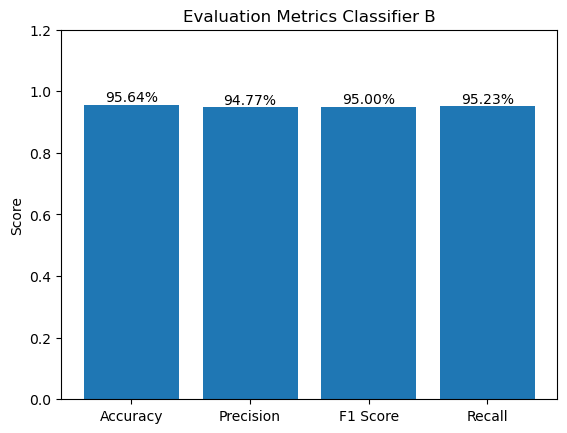

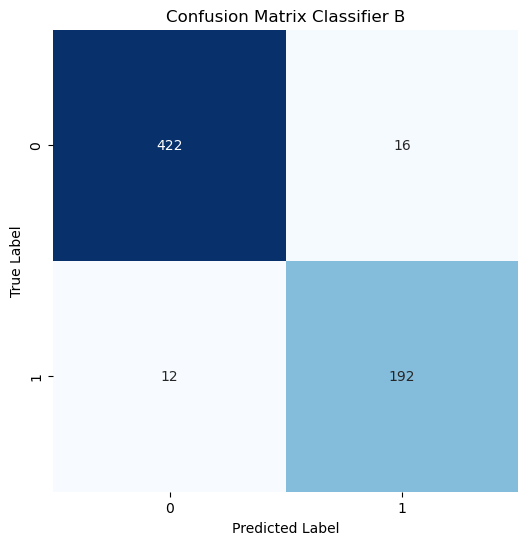

In [8]:
# train the model
trained_model_B = train_classifier_B(train_df, valid_df)